In [5]:
# ECE60146 HW7
# Zhengxin Jiang
# jiang839

import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO
import seaborn as sn 
import random
import json
import math

import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision
import torchvision.transforms as tvt
from torch.utils.data import DataLoader

import cv2

# from pytorch_fid.fid_score import calculate_activation_statistics, calculate_frechet_distance
# from pytorch_fid.inception import InceptionV3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [14]:
# The Dataset class for hw7
class hwDataset(torch.utils.data.Dataset):
    
    def __init__(self, root, tasktype):
        super().__init__()
        
        if tasktype == 'training':
            self.root = os.path.join(root, 'hw7', 'train').replace("\\","/")  
            self.idx_offset = 1001
        if tasktype == 'validation':
            self.root = os.path.join(root, 'hw7', 'eval').replace("\\","/")
            self.idx_offset = 1
        
    def __len__(self):
        return len(os.listdir(self.root))
        
    def __getitem__(self, index):   
        
        filename = str(index+self.idx_offset).zfill(5)+'.jpg'
        img = Image.open(os.path.join(self.root, filename).replace("\\","/"))
        
        tr = tvt.Compose([
            tvt.ToTensor(),
            tvt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        img_tensor = tr(img)
        
        return img_tensor

# The generator network    
class generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.main(x)
    
# The discriminator network    
class discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            
        )
        
    def forward(self, x):
        return self.main(x)
    
class critic(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 512, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Linear(512, 1)
            
        )
        
    def forward(self, x):
        x = self.main(x)
        x = x.mean(0) 
        x = x.view(1)
        
        return x
    
    

        
# custom weights initialization called on netG and netD
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)        
        

In [7]:
root = 'D:/coco'

lr = 0.0001
batch_size = 128
epochs = 100

In [15]:
traindataset = hwDataset(root, 'training')
train_data_loader = DataLoader(traindataset, batch_size=batch_size, num_workers=0, shuffle=True)

In [78]:
##### Training #####
netG = generator()
netG = netG.to(device)
netD = discriminator()
netD = netD.to(device)

netG.apply(weights_init)
netD.apply(weights_init)

criterion = nn.BCELoss()

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

G_losses = []
D_losses = []

for epoch in range(epochs): 
    g_loss = 0.0 
    d_loss = 0.0 
    
    for i, data in enumerate(train_data_loader):
        
        bsize = data.size(0)
        inputs = data.to(device)
        label = torch.full((bsize,), 1, dtype=torch.float, device=device)
        
        ## update discriminator
        ## train with real images
        netD.zero_grad()
        output = netD(inputs)
        
        errD_real = criterion(output.view(-1), label)
        errD_real.backward()
        
        ## train with fake images
        noise = torch.randn(bsize, 100, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0)
        
        output = netD(fake.detach())
        errD_fake = criterion(output.view(-1), label)
        errD_fake.backward()
        
        errD = errD_real + errD_fake
        optimizerD.step()
        
        ## update generator
        netG.zero_grad()
        label.fill_(1)
        
        output = netD(fake) # another forward pass in D
        errG = criterion(output.view(-1), label)
        errG.backward()
        optimizerG.step()
        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, i, len(train_data_loader),
                     errD.item(), errG.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())


[0/10][0/129]	Loss_D: 1.4344	Loss_G: 6.0456
[0/10][50/129]	Loss_D: 0.5708	Loss_G: 10.1755
[0/10][100/129]	Loss_D: 0.3165	Loss_G: 4.7506
[1/10][0/129]	Loss_D: 0.3301	Loss_G: 3.5259
[1/10][50/129]	Loss_D: 0.7205	Loss_G: 8.3481
[1/10][100/129]	Loss_D: 0.3408	Loss_G: 6.6080
[2/10][0/129]	Loss_D: 0.3691	Loss_G: 6.6457
[2/10][50/129]	Loss_D: 0.6459	Loss_G: 6.0067
[2/10][100/129]	Loss_D: 0.3874	Loss_G: 5.4891
[3/10][0/129]	Loss_D: 0.5438	Loss_G: 2.6551
[3/10][50/129]	Loss_D: 0.2890	Loss_G: 4.6204
[3/10][100/129]	Loss_D: 0.4871	Loss_G: 5.5013
[4/10][0/129]	Loss_D: 0.6915	Loss_G: 6.8826
[4/10][50/129]	Loss_D: 0.4951	Loss_G: 4.1452
[4/10][100/129]	Loss_D: 0.6636	Loss_G: 6.8792
[5/10][0/129]	Loss_D: 0.3120	Loss_G: 6.9154
[5/10][50/129]	Loss_D: 0.7597	Loss_G: 6.8810
[5/10][100/129]	Loss_D: 1.1131	Loss_G: 8.9067
[6/10][0/129]	Loss_D: 0.2321	Loss_G: 4.4432
[6/10][50/129]	Loss_D: 0.8041	Loss_G: 4.1775
[6/10][100/129]	Loss_D: 0.6635	Loss_G: 7.2896
[7/10][0/129]	Loss_D: 2.8151	Loss_G: 11.5715
[7/10][50

In [35]:
##### Training WGAN #####
netG = generator()
netG = netG.to(device)
netD = critic()
netD = netD.to(device)

netG.apply(weights_init)
netD.apply(weights_init)

# criterion = nn.BCELoss()

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

G_losses = []
D_losses = []

one = torch.FloatTensor([1]).to(device) 
minus_one = torch.FloatTensor([-1]).to(device)

for epoch in range(epochs): 
    g_loss = 0.0 
    d_loss = 0.0 
    
    for i, data in enumerate(train_data_loader):
        
        bsize = data.size(0)
        inputs = data.to(device)
        label = torch.full((bsize,), 1, dtype=torch.float, device=device)
        
        ## update discriminator
        ## train with real images
        netD.zero_grad()
        output = netD(inputs)
        
        errD_real = output
        errD_real.backward(minus_one)
        
        ## train with fake images
        noise = torch.randn(bsize, 100, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0)
        
        output = netD(fake.detach())
        errD_fake = output
        errD_fake.backward(one)
        
        errD = errD_real + errD_fake
        optimizerD.step()
        
        ## update generator
        netG.zero_grad()
        label.fill_(1)
        
        output = netD(fake) # another forward pass in D
        errG = output
        errG.backward(minus_one)
        optimizerG.step()
        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, i, len(train_data_loader),
                     errD.item(), errG.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

[0/100][0/65]	Loss_D: -0.0138	Loss_G: -2.7760
[0/100][50/65]	Loss_D: 5.7141	Loss_G: -167.6950
[1/100][0/65]	Loss_D: -37.8185	Loss_G: -315.7938
[1/100][50/65]	Loss_D: 371.0122	Loss_G: -1103.5356
[2/100][0/65]	Loss_D: -181.7937	Loss_G: -1533.6589
[2/100][50/65]	Loss_D: 3179.4990	Loss_G: 1155.0754
[3/100][0/65]	Loss_D: 1075.8068	Loss_G: -819.3812
[3/100][50/65]	Loss_D: -1503.0004	Loss_G: -3369.2234
[4/100][0/65]	Loss_D: 6925.6855	Loss_G: 2835.4497
[4/100][50/65]	Loss_D: -451.0244	Loss_G: -5436.6987
[5/100][0/65]	Loss_D: -1271.4717	Loss_G: -5882.7900
[5/100][50/65]	Loss_D: 12247.6465	Loss_G: 4040.4189
[6/100][0/65]	Loss_D: 8653.3330	Loss_G: 3220.7920
[6/100][50/65]	Loss_D: -4982.4087	Loss_G: -7470.9141
[7/100][0/65]	Loss_D: 353.6494	Loss_G: -9452.7080
[7/100][50/65]	Loss_D: 5345.2666	Loss_G: -12764.9043
[8/100][0/65]	Loss_D: -5208.3306	Loss_G: -12492.0186
[8/100][50/65]	Loss_D: -13428.7305	Loss_G: -16586.7812
[9/100][0/65]	Loss_D: -1735.4365	Loss_G: -17555.5859
[9/100][50/65]	Loss_D: 39164

[74/100][50/65]	Loss_D: -111257.2500	Loss_G: -1648639.6250
[75/100][0/65]	Loss_D: 1475808.0000	Loss_G: 485977.8125
[75/100][50/65]	Loss_D: -186842.1250	Loss_G: -1670724.5000
[76/100][0/65]	Loss_D: 1203459.2500	Loss_G: -1773400.7500
[76/100][50/65]	Loss_D: -130195.5000	Loss_G: -1779823.6250
[77/100][0/65]	Loss_D: 355075.3750	Loss_G: -1595511.8750
[77/100][50/65]	Loss_D: -150226.6250	Loss_G: -1796324.7500
[78/100][0/65]	Loss_D: 113513.5000	Loss_G: -1853567.5000
[78/100][50/65]	Loss_D: -139099.2500	Loss_G: -1893448.0000
[79/100][0/65]	Loss_D: -267881.0000	Loss_G: -1872277.0000
[79/100][50/65]	Loss_D: -153755.8750	Loss_G: -1924937.6250
[80/100][0/65]	Loss_D: -109445.3750	Loss_G: -1942640.2500
[80/100][50/65]	Loss_D: -185290.3750	Loss_G: -2002450.7500
[81/100][0/65]	Loss_D: 3171977.5000	Loss_G: 101664.2578
[81/100][50/65]	Loss_D: -94100.1250	Loss_G: -2034450.3750
[82/100][0/65]	Loss_D: 514523.6250	Loss_G: -2095952.0000
[82/100][50/65]	Loss_D: 2058676.5000	Loss_G: -272529.8125
[83/100][0/65]

In [29]:
##### Training WGAN #####
netG = generator()
netG = netG.to(device)
netC = critic()
netC = netC.to(device)

netG.apply(weights_init)
netC.apply(weights_init)

one = torch.FloatTensor([1]).to(device) 
minus_one = torch.FloatTensor([-1]).to(device)

optimizerC = torch.optim.Adam(netC.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

G_losses = []
C_losses = []

clipping_thresh = 0.01
gen_iterations = 0

for epoch in range(epochs): 
    data_iter = iter(train_data_loader)
    i=0
    ncritic = 5
    
    while i < len(train_data_loader):
        ic = 0
        for p in netC.parameters(): 
            p.requires_grad = True
        if gen_iterations < 25 or gen_iterations % 500 == 0: 
            ncritic = 50
            
        while ic < ncritic and i < len(train_data_loader):
            for p in netC.parameters(): 
                p.data.clamp_(-clipping_thresh, clipping_thresh)
            netC.zero_grad()
            data = data_iter.next()
            b_size = data.size(0)
            inputs = data.to(device)

            output_real = netC(inputs)
            output_real.backward(minus_one)

            noise = torch.randn(b_size, 100, 1, 1, device=device) 
            fake = netG(noise)

            output_fake = netC(fake)
            output_fake.backward(one)

            wdist = output_real - output_fake
            errC = output_fake - output_real

            optimizerC.step()

            i += 1
            ic += 1
                
        ## update generator
        for p in netC.parameters(): 
            p.requires_grad = False
        netG.zero_grad()       
        
        noise = torch.randn(b_size, 100, 1, 1, device=device) 
        fakes = netG(noise)
        
        output = netC(fakes)
        output.backward(minus_one)  
        errG = output
                
        optimizerG.step()
        gen_iterations += 1
        print(gen_iterations)
        
        if gen_iterations % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, gen_iterations, len(train_data_loader),
                     errC.item(), errG.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        C_losses.append(errC.item())
        
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
[14/100][50/65]	Loss_D: -7.8632	Loss_G: -3.6734
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
[18/100][100/65]	Loss_D: -7.8431	Loss_G: -3.6663
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
[22/100][150/65]	Loss_D: -7.7916	Loss_G: -3.6625
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
[26/100][200/65]	Loss_D: -7.3072	Loss_G: -3.4802
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
2

In [38]:
## save models
# torch.save(netG.state_dict(), 'G_BCE.pth')
# torch.save(netD.state_dict(), 'D_BCE.pth')
torch.save(netG.state_dict(), 'G_W.pth')
torch.save(netD.state_dict(), 'D_W.pth')

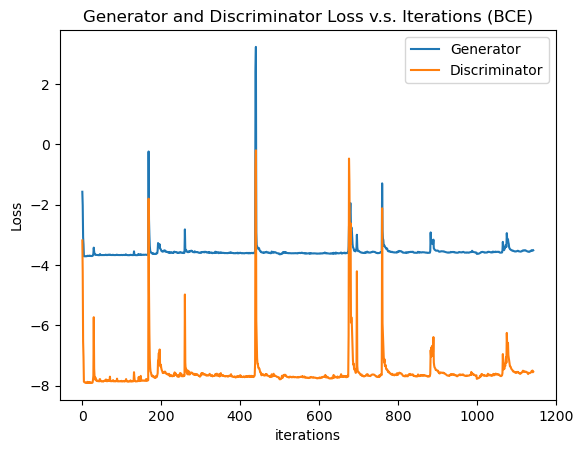

In [31]:
## plot the loss
plt.figure()
plt.title("Generator and Discriminator Loss v.s. Iterations (Wasserstein)")
plt.plot(G_losses,label="Generator")
# plt.plot(D_losses,label="Discriminator")
plt.plot(C_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [82]:
## load models
netG = generator()
netG = netG.to(device)
netD = discriminator()
netD = netD.to(device)

netG.load_state_dict(torch.load('G_BCE.pth', map_location=torch.device(device))) 
netD.load_state_dict(torch.load('D_BCE.pth', map_location=torch.device(device))) 

<All keys matched successfully>

In [36]:
##### Evaluation #####
fake_num = 1000
# fake_folder = 'fake_bce'
fake_folder = 'fake_w'

## generate 1000 fake images
with torch.no_grad():
    noise = torch.randn(fake_num, 100, 1, 1, device=device)
    fake = netG(noise)
    fake = fake.view(fake_num, 3, 64, 64)
    
img_grid = np.transpose(torchvision.utils.make_grid(fake[:16], nrow = 4,
                                                    padding=1, pad_value=1, normalize=True).cpu(),(1,2,0))
    

        

In [37]:
transform = tvt.Compose([
                tvt.Normalize((0,0,0),(2,2,2)), 
                tvt.Normalize((-0.5,-0.5,-0.5,),(1,1,1)),
                tvt.ToPILImage()
            ])
for i in range(fake_num):
    img = transform(fake[i])
    filename = str(i).zfill(5)+'.jpg'
    img.save(os.path.join(root, 'hw7', fake_folder, filename).replace("\\","/"))

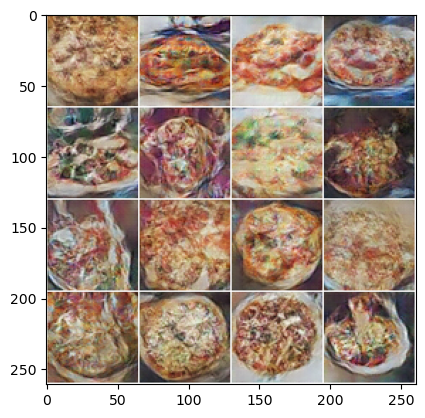

In [107]:
plt.imshow(img_grid)

In [110]:
os.listdir(os.path.join(root, 'hw7', folder).replace("\\","/"))

['00000.jpg',
 '00001.jpg',
 '00002.jpg',
 '00003.jpg',
 '00004.jpg',
 '00005.jpg',
 '00006.jpg',
 '00007.jpg',
 '00008.jpg',
 '00009.jpg',
 '00010.jpg',
 '00011.jpg',
 '00012.jpg',
 '00013.jpg',
 '00014.jpg',
 '00015.jpg',
 '00016.jpg',
 '00017.jpg',
 '00018.jpg',
 '00019.jpg',
 '00020.jpg',
 '00021.jpg',
 '00022.jpg',
 '00023.jpg',
 '00024.jpg',
 '00025.jpg',
 '00026.jpg',
 '00027.jpg',
 '00028.jpg',
 '00029.jpg',
 '00030.jpg',
 '00031.jpg',
 '00032.jpg',
 '00033.jpg',
 '00034.jpg',
 '00035.jpg',
 '00036.jpg',
 '00037.jpg',
 '00038.jpg',
 '00039.jpg',
 '00040.jpg',
 '00041.jpg',
 '00042.jpg',
 '00043.jpg',
 '00044.jpg',
 '00045.jpg',
 '00046.jpg',
 '00047.jpg',
 '00048.jpg',
 '00049.jpg',
 '00050.jpg',
 '00051.jpg',
 '00052.jpg',
 '00053.jpg',
 '00054.jpg',
 '00055.jpg',
 '00056.jpg',
 '00057.jpg',
 '00058.jpg',
 '00059.jpg',
 '00060.jpg',
 '00061.jpg',
 '00062.jpg',
 '00063.jpg',
 '00064.jpg',
 '00065.jpg',
 '00066.jpg',
 '00067.jpg',
 '00068.jpg',
 '00069.jpg',
 '00070.jpg',
 '0007

In [9]:
len(train_data_loader)

65